<a href="#Overview"></a>
# Overview
* <a href="#2ac9000c-d3d8-42f8-990b-12d9773841ac"> Current Source Density Analysis - Spatial Filtering</a>
  * <a href="#f787f011-b248-43d1-ac35-fe89bd9e0b8a">How can we leverage the spatial resolution given by mulitelectrode recording to identify local changes in activity? </a>
    * <a href="#cc293f61-ee6a-4fc7-882f-4cf6cf86f5fa">Function list</a>
* <a href="#ff883a2e-af5b-4f66-b4f1-c3b9603e1f7c">Load the data</a>
  * <a href="#2f6b1cf2-05a4-4988-a27e-b4fcb03cd8de">Exercise 1: load the correct files</a>
* <a href="#c4db9fb7-c992-4848-b9e3-c99056834d30">Signal processing/data cleaning</a>
  * <a href="#b55f8f55-79bd-427b-a550-0c4fbedaba1d">Exercise 2: Create a filter to isolate signal2 </a>
  * <a href="#b55f8f55-79bd-427b-a550-0c4fbedaba1d">Exercise 3: Filter the data to isolate LFP and MUA </a>
* <a href="#c4db9fb7-c992-4848-b9e3-c99056834d30">Trial averaging the data</a>
  * <a href="#b55f8f55-79bd-427b-a550-0c4fbedaba1d">Exercise 4: Using trial epochs, trialize the lfp and mua </a>
  * <a href="#b55f8f55-79bd-427b-a550-0c4fbedaba1d">Exercise 5: Trial average the data</a>
* <a href="#c4db9fb7-c992-4848-b9e3-c99056834d30">Isolate single column</a>
  * <a href="#b55f8f55-79bd-427b-a550-0c4fbedaba1d">Exercise 6: Using trial epochs, trialize the lfp and mua </a>
  * <a href="#b55f8f55-79bd-427b-a550-0c4fbedaba1d">Exercise 7: Trial average the data</a>
* <a href="#c4db9fb7-c992-4848-b9e3-c99056834d30">Spatial smoothing to reduce electrode to electrode variability</a>
  * <a href="#b55f8f55-79bd-427b-a550-0c4fbedaba1d">Exercise 8: Use a hanning window to spatially smooth data  </a>
* <a href="#c4db9fb7-c992-4848-b9e3-c99056834d30">Estimating current source density - second spatial derivative estimation </a>
  * <a href="#b55f8f55-79bd-427b-a550-0c4fbedaba1d">Exercise 9: Formalize the equation provided in code </a>
  * <a href="#b55f8f55-79bd-427b-a550-0c4fbedaba1d">Exercise 10: Loop through the data and approximate the CSD </a>
* <a href="#c4db9fb7-c992-4848-b9e3-c99056834d30">Plotting the CSD </a>
  * <a href="#b55f8f55-79bd-427b-a550-0c4fbedaba1d">Exercise 11: Use imshow to plot the generated CSD estimate </a>

<a id="2ac9000c-d3d8-42f8-990b-12d9773841ac"></a>
# Current Source Density Analysis 
<a href="#Overview">Return to overview</a>

<a id="f787f011-b248-43d1-ac35-fe89bd9e0b8a"></a>
## How can we highlight local aspects of electrophysiology data in the presence of volume conduction? Can we identify the laminar structure of the auditory cortex given a laminar array of electrodes and auditory stimuli?
<a href="#Overview">Return to overview</a>

Individual neurons act as sources and sinks of current forming dipole moments. Depending on the anatomy of the given brain region being recorded from, neurons are often aligned forming larger cumulative dipoles that are picked up by the recording electrode. If the dipole moment for two neurons are not aligned this can effectively cancel out. Fortunately, cortex has fairly regular laminar structure with many neurons having similar alignments. When a neuron receives input at its dendrites and channels open allowing positively chareged ions in this leads to a negative deflection in the extracellularly recorded potentials (called a current sink), and the extracellular space farther away from this sink will be more positive and will be a source for return current (current source). <i>


<p style="text-align: center;"><img src="images/sources and sinks.png" alt="drawing" width="500"/></p>


The activity at recording electrodes reflects a mixture of local activity and activity from neighboring sources that can propogate via the conductive media of the brain. We want to reduce this volume conducted signal to identify local positive (sources) and negative (sinks) in the LFP signal which can reflect localized neural activity. To address this issue, we can simply take the spatial derivative, the change in voltage per distance, given the known spacing of contact sites. This is typically called current source density analysis when applied to multicontanct probes in the brain and has been used to identify local activity patterns associated with laminar processing. For a more thorough background, see Neuromethods (2012) 67: 205–218 DOI 10.1007/7657_2011_6. 
    
<p style="text-align: center;"><img src="images/laminar_probe_CSD.png" alt="drawing" align="center" width="500"/></p>

We will now go through some of the basic signal processing steps needed to estimate the CSD for laminar probes.

<a id="cc293f61-ee6a-4fc7-882f-4cf6cf86f5fa"></a>
### Function list
<a href="#Overview">Return to overview</a>

Numpy
* `np.sin()
*  np.pi()
*  np.hanning()

Matplotlib (these are not central to today's presentation but are good to know about). We'll mostly be using plot functions that we already know.
* `plt.subplots`
* `plt.errorbar`

Scipy
* `scipy.signal.butter()
*  scipy.signal.sosfilt()
*  scipy.signal.convolve2d()

<a id="ff883a2e-af5b-4f66-b4f1-c3b9603e1f7c"></a>
# Load the data
<a href="#Overview">Return to overview</a>


First, import the requisite libraries. You should already have all these installed in your Anaconda environment.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
import tables as tb
from scipy.signal import convolve2d, butter, sosfilt
import pycurl


<a id="2f6b1cf2-05a4-4988-a27e-b4fcb03cd8de"></a>
## Exercise 1: load the data
<a href="#Overview">Return to overview</a>

Raw (1500Hz lowpass filtered and downsampled for sake of convenience)- data from a 64 channel silicone probe recording made in ferret primary auditory cortex neurons has been stored in a .hdf5 file in the `data/` subdirectory. This is the same general file type as the data from week 4 image processing and can be accessed with the tables module, tb. This file should contain the raw voltage data and epoch timestamps surrounding the stimuli.

Remember, the tb module has a function, open_file, that will let us store a "File" object needed to access the data. Once we have a file handle object we can use the print function to get some basic information about the directories it contains. Using the directory information obtained with the print function, try to load the data from the probe into 2 separate variables called "probedata", "epochs".

In [13]:
import pycurl

# As long as the file is opened in binary mode, both Python 2 and Python 3
# can write response body to it without decoding.
with open('data/TAR010a.h5', 'wb') as f:
    c = pycurl.Curl()
    c.setopt(c.URL, 'https://hearingbrain.org/tmp/TAR010a.h5')
    c.setopt(c.WRITEDATA, f)
    c.perform()
    c.close()

b'This is a test.\n\n'

In [21]:
#load file
fh = tb.open_file('data/TAR010a.h5')

#print file directories
print(fh)

data/TAR010a.h5 (File) ''
Last modif.: 'Sat Feb  5 23:04:13 2022'
Object Tree: 
/ (RootGroup) ''
/epochs (Array(60, 2)) ''
/probedata (Array(64, 361165)) ''
/stim (Array(60,)) ''



In [22]:
#load probedata
node = fh.get_node('/probedata')
probedata = node.read()
print(probedata.shape)

(64, 361165)


In [23]:
#load trial epochs
node = fh.get_node('/epochs')
epochs = node.read()
print(epochs.shape)

(60, 2)


# Signal processing

Often times, we have data that we know has multiple unique sources in it, noise, or components that are not of interest given a particular question. In extracellular electrophysiology data there are often multiple components we are interested in, AP/spikes - voltage fluctaions on the order of 1-2ms due to fast Na+/K+ channel dynamics and the local field potential (LFP) - thought to primarily reflect slower timescale channels (AMPA/GABA) as well as synchronous spiking near the electrode. Although somewhat arbitrary, we can typically separate these different features of interest by filtering the data. Here we will briefly go over signal filtering which is an important step in many signal processing pipelines.

To demonstrate the basics of signal filtering, lets create two simple signals with different frequency characterstics and then use a filter to separate them again.

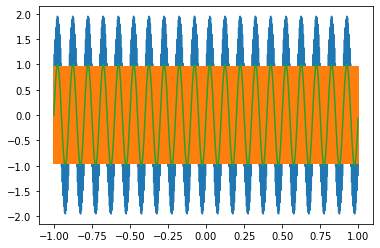

In [24]:
#simulation parameters
freq1 = 10
freq2 = 800
fs = 1000
time = np.arange(-1, 1, 1/fs)

#create signals
signal1 = np.sin(2*np.pi*freq1*time)
signal2 = np.sin(2*np.pi*freq2*time)

#combine signals
combined = signal1 + signal2

#plot combined signal
plt.plot(time, combined)
plt.plot(time, signal2)
plt.plot(time, signal1)

Lets use a filter to separate the two known sources.

A butterworth filter is a commonly used filter that has a flat profile in the pass band, the frequencies that it lets
through won't have amplitude distortions or ringing effects that some other filter kernels create. Scipy has a nice function that lets us design our own butterworth filter.

The major parameters to be considered are the filter order, which is essentially the length of our filter kernel. This parameter specifies length based on a multiple of the the lowest frequency asked for in the cutoff frequency. In general, this should be larger than 3 which is the default. The larger the filter order, the better the filter frequency precision although this comes at a drawback of increased computation time and creates a shift in the phase of the signal (this can be corrected for so it is not a big deal). The other parameters are the cutoff frequencies/passband which specifies the frequencies that we want to filter out of our signal, the filter type (low, high, bandpass), and the sampling frequency. One common way to implement a filter is a second order sections method which we implement here.

For more information regarding filters, I'd recommend Mike X Cohens book analyzing neural time series which has a whole chapter devoted to properly designing filters. Additonally, The scientists and engineers guide to digital signal processing is freely available although a bit more dense and less fun https://www.dspguide.com/.

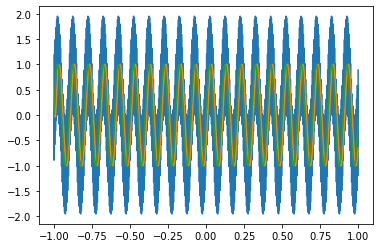

In [25]:
#filter parameters
order = 5
passband = 50

#design filter
sos = scipy.signal.butter(order, passband, 'lowpass', fs=fs, output='sos')

#filter data
signal1filt = scipy.signal.sosfilt(sos, combined)

#plot signals
plt.figure()
plt.plot(time, combined)
plt.plot(time, signal1filt)
plt.plot(time, signal1)

This example is extremely basic, but it shows that our filter can essentialy extract one signal from a combined signal. Which is pretty cool.

## Exercise 2: Create a filter to isolate the higher frequency signal

Now that you have some experience with filtering, design a filter to extract the high frequency component of the combined signal we generated and save it as "signal2filt". Then plot the first 100 samples of your filter signal and the original high frequency signal. 

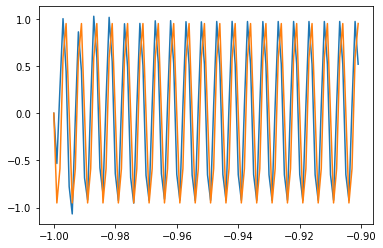

In [26]:
order = 5
passband = 50
sos = scipy.signal.butter(order, passband, 'highpass', fs=fs, output='sos')

signal2filt = scipy.signal.sosfilt(sos, combined)

plt.figure()
plt.plot(time[:100], signal2filt[:100])
plt.plot(time[:100], signal2[:100])

## Exercise 3: Filter raw data to extract the local field potential and the multiunit activty


As stated earlier, the data has been lowpass filtered and downsampled below 1500Hz. This means the signal should contain the low frequency signal neuroscientists typically refer to as the local field potential as well as high frequency spiking related activity although the sampling rate and filter are much too low to identify spike waveforms we will use this activity as a measure of what is typically refered to as multiunit activity or general spike related activity. 

Given our experience with butterworth filters, lets filter the data to create a signal called "mua" that contains data high-pass filtered above 100Hz. Lets also save the local field potential activity in a variable called "lfp" that is bandpassfiltered between 1 and 150Hz. It is worth noting that our data currently has multiple dimensions and can be filtered along any of them. We want to filter along the time dimension
so we will need to use an additional input in sosfilt to specify the axis we want to filter along.

In [27]:
#filter mua
fs = 1500
sos = scipy.signal.butter(4, 100, 'highpass', fs=fs, output='sos')
mua = scipy.signal.sosfilt(sos, probedata, axis=1)


#filter lfp
sos = butter(4, [1, 150], 'bandpass', fs=fs, output='sos')
lfp = sosfilt(sos, probedata, axis=1)


Spiking activity has negative and positive deflections and we want to convert this into an amplitude profile for cleaner viewing and interpretation. To do this, we will take the absolute value of this signal with numpy's abs function. np.abs(data) will take the absolute value of the input. Try this for the filtered mua. 

In [28]:
#extract mua amplitude
mua = np.abs(mua)

# Trial averaging the data

Although you can take CSD estimates for individual trials CSD is often estimated on trialized data which low pass filters the data to some extent creating a cleaner estimate. We have a list of tuples for each trial in the epochs data which has the start time of the trial epoch and the stop time of the trial epoch. The epochs contain a 0.5 second prestimulus silence followed by a tone and post stimulus silence period. Try to find out how long the epochs are.

In [29]:
#Take the epoch end and subtract the epoch start to look at length
print((epochs[:, 1] - epochs[:, 0]))

[1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6
 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6
 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6
 1.6 1.6 1.6 1.6 1.6 1.6]


## Exercise 4: extracting event data and trial averaging

Given the knowledge about the epochs, use the first and last value in each row of the epochs data (the start and end of the trial epoch), to slice out these epochs for both mua and lfp. Check and make sure the ending dimensions match what is expected.

In [30]:
#extract stim events
epochlen = int(1.6*1500)

#convert epoch times to sample numbers
epochs = epochs*fs

#make a trial list
lfp_trials = np.zeros((60, 64, epochlen))
mua_trials = np.zeros((60, 64, epochlen))
#loop through list of epochs and for each epoch extract 
for i in range(60):
    lfp_trials[i, :] = lfp[:, round(epochs[i, 0]):round(epochs[i, 1])]
    mua_trials[i, :] = mua[:, round(epochs[i, 0]):round(epochs[i, 1])]
    
#sanity check that data shape is correct
np.shape(lfp_trials),np.shape(mua_trials)  


((60, 64, 2400), (60, 64, 2400))

Take the mean of both the mua and the lfp over all 60 trials and plot the first channel of averaged data.

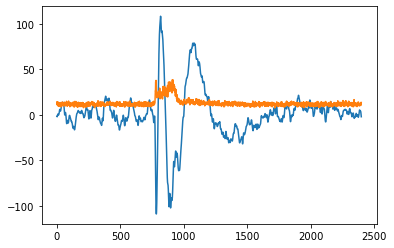

In [33]:
#trial average the data along the trials dimension

lfp_tavg = lfp_trials.mean(axis = 0)
mua_tavg = mua_trials.mean(axis = 0)

plt.plot(lfp_tavg[0, :])
plt.plot(mua_tavg[0, :])


# Taking a single column of electrodes

The method of CSD estimation that we are using is easiest to implement for uniform grids. The probes in this dataset have an unique arrangement with 3 columns of uniformly spaced electrodes that are 50 microns apart. We'll extract a single uniformly spaced column and estimate the CSD from that.

In [34]:
#Here are the channel numbers for each of the the three columns of electrodes
left_ch_nums = np.arange(3,64,3)-1
right_ch_nums = np.arange(4,65,3)-1
center_ch_nums = np.insert(np.arange(5, 63, 3),obj=slice(0,1),values =[1,2],axis=0)-1

Using the channel maps provided above slice out the center column of electrodes and save as "lfp_tavg_cent" and "mua_tavg_cent".

In [35]:
lfp_tavg_cent = lfp_tavg[center_ch_nums]
mua_tavg_cent = mua_tavg[center_ch_nums]

In this particular case, we are also going to apply a spatial hanning window filter to smooth the data between electrodes. To do this, we generate a hanning window, a tapered function, and by applying this taper across the channels each point becomes a weighted sum of itself and its neighbors. This should smooth or decrease channel to channel variability that may show up in CSD which emphasizes local differences.

In [36]:
#Using np.hanning we can create a hanning window to use to smooth our data. np.hanning takes one input which determines the number of samples used
#to create the window. We will use 5 for this which will mean we are estimating each electrode given two contacts on either side.

spatial_filter = np.hanning(5)[:, np.newaxis]

#We will scale it by the sum of the filter so that the total value of the filter is 1. 
spatial_filter = spatial_filter / spatial_filter.sum()

#convolution will take the sliding dot product of our filter with our data which smooths the data by estimating each point as the weighted sum of its neighbors.
#the result of convolution can be forced to be the same size as the first input with mode = same.
CSD_formatted = convolve2d(lfp_tavg_cent, spatial_filter, mode='same', boundary='symm')

# Current source density algorithm - estimating the second spatial derivative

The second spatial derivative is often approximated by a three point formula involving taking the difference in voltage over space between two pairs of points - (voltage(x + some distance) - voltage(x)) - ((voltage(x) - voltage(x - some distance)). This is then normalized by the square of the distance - (some distance)^2. The distance chosen is a parameter that can vary and may impact the spatial resolution of identified sources and sinks. In the example from Higley, Neuromethods (2020), delta v is 200 microns as they choose to skip the nearest contact site in a probe with 100 micron spacing. This value may vary depending on your recording setup and anatomical considerations. Here we will just set the distance to one contact site.

<p style="text-align: center;"><img src="images/CSD equation.png" alt="drawing" width="500"/></p>


From the above equations, it should be apparrent that we will not be able to estimate the CSD at top or bottom electrode because we don't have a point above or below these electrodes respectively to perform the calculation. Although dubious, it is often the case that groups will extend/duplicate the data from the top and bottom electrodes under the assumption that the voltage recorded at nearby electrodes is not drastically different and therefore will not greatly impact the estimation. We will avoid doing this here and will simply lose data on both of these channels.

Try to convert the equation from up above into code with the channel spacing, detla V, set to 50 microns. Also instead of skipping the neighboring site in our estimation lets use the nearest neighbor. Normalize by the square of the delta V.

In [37]:
#delta z
ch_spacing = 50

#initialize a vector of expected output
CSD_est = np.zeros_like(lfp_tavg_cent[:20, :])

#loop through each channel and estimate the CSD along the time dimension
for i in range(0, 20):
    V0 = CSD_formatted[i + 1, :]
    Va = CSD_formatted[i, :]
    Vb = CSD_formatted[i + 2, :]
    CSD_est[i, :] = (Vb + Va - 2*V0)/(ch_spacing)**2


Plotting of CSD is often done with the sign of values flipped so that sinks appear as positive warmer and sources appear as blue. Try to flip the sign of all the values in CSD_est.

In [38]:
#flip sign of CSD for plotting purposes
CSD_est = -CSD_est

# Plot the estimated CSD

Try using plt.imshow() to plot the CSD_est we just generated. Remember, imshow defaults to the origin being in the upper right which has be corrected with an additional parameter. In this case, the units of the x and y axis are not the same so try to find a way to adjust the aspect ratio to keep the axes fixed as this parameter defaults to 1 as it assumes we want square pixels as in images.

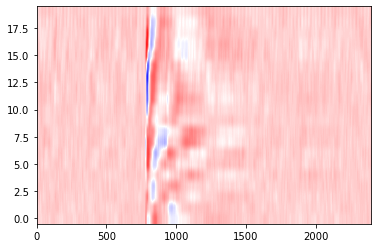

In [39]:
plt.figure()
plt.imshow(CSD_est, origin = 'lower', aspect = 'auto', cmap = 'bwr')

This looks good. However, we are plotting more data than necessary. The majority of the interesting components happen right around sample 750. This corresponds to the stimulus following a 0.5 second delay. Lets look at 0.05 seconds prestimulus and 0.15 seconds poststimulus. Try to slice and plot the data around this timeframe to see if it looks better.

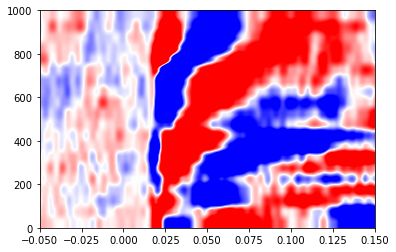

In [40]:
#define time for plotting
prestim = 750/1500
poststim = 1650/1500
time = np.arange(-prestim, poststim, 1/fs)
mask = (time > -.05) & (time < 0.15)
plt.figure()
plt.imshow(CSD_est[:, mask], extent = [-.05, .15, 0, 1000], origin = 'lower', aspect = 'auto', vmin = - .001, vmax = .001, cmap = 'bwr')


Great! But what, if anything, do these stimulus evoked sources and sinks tell us about neuroanatomy?

"Noise-evoked columnar CSD patterns were used to determine the location of the A1 recording channel. Two CSD signatures were
used to identify L4: A brief current sink first occurs approximately 10 ms after the noise onset, which was used to determine the lower
border of L4 (Kaur et al., 2005). A triphasic CSD pattern (sink-source-sink from upper to lower channels) occurs between 20 ms and
50 ms, where the border between the upper sink and the source was used to define the upper boundary of L4. Normally, 2 channels
were assigned to L4. Other layers were defined relative to the location of L4 (L2/3: 3 channels above L4; L5: 3 channels below L4; L6: 3
channels below L5). CSD-derived layer assignments were cross-validated against sound-evoked MUA response patterns, where L4
and L5 units responded with higher firing rates and shorter latency."
(Guo et al 2017)

Given this knowledge, lets place a vertical ine on our plot at 10ms which should be near the first sink in the signal and might help visualize it.

Also, we have mua data that we filtered. Try to plot this overtop of the CSD plot. Our y axis in the CSD is related to electrode position in microns. Try to use the knowledge that each channel is spaced 50 microns appart as well as the fact that the mua signal is close to 0 mV at rest to separate out the channels based on spatial location.

Text(0, 0.5, 'Position from recording tip (microns)')

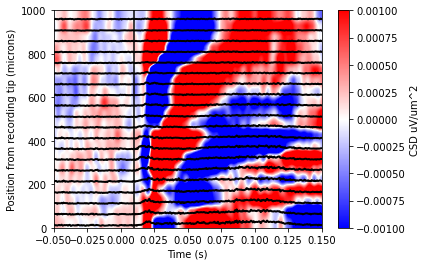

In [41]:
ch_map = np.arange(0, 20*50, 50)
plt.figure()
plt.imshow(CSD_est[:, mask], extent = [-.05, .15, 0, 1000], origin = 'lower', aspect = 'auto', vmin = - .001, vmax = .001, cmap = 'bwr')
cbar = plt.colorbar()
cbar.set_label("CSD uV/um^2")
for i in range(len(mua_tavg_cent)-2):
    plt.plot(time[mask], (mua_tavg_cent[i+1, mask] + np.repeat(ch_map[i], len(mua_tavg_cent[i+1, mask]))), linewidth = 2, color = 'k')
plt.axvline(x = 0.01, color = 'k', label = 'axvline - full height')
plt.xlabel("Time (s)")
plt.ylabel("Position from recording tip (microns)")